In [262]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge

from joblib import dump, load

from scipy.stats import loguniform



In [177]:
base_path = "../data/ubc-pair-grade-data"
file_paths = ["tableau-dashboard/UBCV", "tableau-dashboard-v2/UBCV"]

df = pd.DataFrame()

for file_path in file_paths:
    for year_folder in os.listdir(os.path.join(base_path, file_path)):
        for file in os.listdir(os.path.join(base_path, file_path, year_folder)):
            if file.endswith(".csv"):
                df = pd.concat([df, pd.read_csv(os.path.join(base_path, file_path, year_folder, file))])

df.to_csv("../data/ubcv_grades_tableau_all.csv", index=False)

display(df.head())


,Campus,Year,Session,Subject,Course,Detail,Section,Title,Professor,Enrolled,...,68-71,72-75,76-79,80-84,85-89,90-100,Reported,Median,Percentile (25),Percentile (75)
0,UBCV,2020,W,FIST,100,NaN,001,Introduction to Film Studies,Alexander Christensen;Alexander Clayton Christ...,109.0,...,9.0,13.0,10.0,28.0,19.0,4.0,NaN,NaN,NaN,NaN
1,UBCV,2020,W,FIST,100,NaN,003,Introduction to Film Studies,Angela Morrison;Christine Evans;Gerrit Krueper...,96.0,...,11.0,9.0,9.0,26.0,19.0,4.0,NaN,NaN,NaN,NaN
2,UBCV,2020,W,FIST,100,NaN,004,Introduction to Film Studies,Brent Strang;Harrison Wade;Jemma Dashkewytch;K...,96.0,...,10.0,8.0,15.0,18.0,24.0,7.0,NaN,NaN,NaN,NaN
3,UBCV,2020,W,FIST,100,NaN,OVERALL,Introduction to Film Studies,NaN,301.0,...,30.0,30.0,34.0,72.0,62.0,15.0,NaN,NaN,NaN,NaN
4,UBCV,2020,W,FIST,200,NaN,002,Introduction to Canadian Cinema,Christine Evans;Mila Zuo,40.0,...,2.0,3.0,5.0,12.0,14.0,0.0,NaN,NaN,NaN,NaN


In [178]:
df.shape

(108741, 29)

In [179]:
df.describe()

,Year,Course,Enrolled,Avg,Std dev,High,Low,<50,50-54,55-59,...,68-71,72-75,76-79,80-84,85-89,90-100,Reported,Median,Percentile (25),Percentile (75)
count,108741.000000,108741.000000,86089.000000,108741.000000,86089.000000,108741.000000,108741.000000,96947.000000,94292.000000,93306.000000,...,93906.000000,94655.000000,94966.000000,97550.000000,96087.00000,96656.000000,22652.000000,22652.000000,22652.000000,22652.000000
mean,2018.095015,370.216101,58.361417,80.389060,8.818913,93.072263,52.279177,1.931839,1.341620,1.843097,...,5.006709,6.686092,7.742824,11.811481,10.12598,9.650255,50.250839,82.665791,77.339091,86.965191
std,2.722866,143.871306,111.808296,7.269498,5.273125,4.572997,27.671616,7.673842,5.253221,6.623180,...,12.602954,14.887591,15.137324,19.673887,15.12103,21.162198,59.917795,6.937902,9.236363,5.502243
min,2014.000000,1.000000,5.000000,18.300000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,...,-9.000000,-8.000000,-15.000000,-22.000000,-30.00000,-62.000000,6.000000,20.000000,0.000000,20.000000
25%,2016.000000,271.000000,15.000000,75.200000,4.685337,90.000000,33.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,3.000000,3.00000,1.000000,17.000000,78.000000,71.000000,83.000000
50%,2018.000000,388.000000,30.000000,80.209302,7.873403,94.000000,60.000000,0.000000,0.000000,0.000000,...,1.000000,3.000000,4.000000,7.000000,6.00000,5.000000,30.000000,82.500000,77.250000,87.000000
75%,2020.000000,500.000000,60.000000,85.894737,12.056059,97.000000,75.000000,1.000000,1.000000,1.000000,...,6.000000,8.000000,10.000000,14.000000,12.00000,11.000000,57.000000,88.000000,84.000000,91.000000
max,2023.000000,769.000000,3389.000000,100.000000,43.259186,100.000000,100.000000,328.000000,185.000000,239.000000,...,492.000000,650.000000,596.000000,618.000000,423.00000,1927.000000,1643.000000,100.000000,100.000000,100.000000


In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108741 entries, 0 to 3
Data columns (total 29 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Campus           108741 non-null  object 
 1   Year             108741 non-null  int64  
 2   Session          108741 non-null  object 
 3   Subject          108741 non-null  object 
 4   Course           108741 non-null  int64  
 5   Detail           19139 non-null   object 
 6   Section          108741 non-null  object 
 7   Title            108718 non-null  object 
 8   Professor        72666 non-null   object 
 9   Enrolled         86089 non-null   float64
 10  Avg              108741 non-null  float64
 11  Std dev          86089 non-null   float64
 12  High             108741 non-null  float64
 13  Low              108741 non-null  float64
 14  <50              96947 non-null   float64
 15  50-54            94292 non-null   float64
 16  55-59            93306 non-null   float64
 17  6

In [181]:
df.isna().sum()

Campus                 0
Year                   0
Session                0
Subject                0
Course                 0
Detail             89602
Section                0
Title                 23
Professor          36075
Enrolled           22652
Avg                    0
Std dev            22652
High                   0
Low                    0
<50                11794
50-54              14449
55-59              15435
60-63              15848
64-67              15675
68-71              14835
72-75              14086
76-79              13775
80-84              11191
85-89              12654
90-100             12085
Reported           86089
Median             86089
Percentile (25)    86089
Percentile (75)    86089
dtype: int64

In [182]:
df['Year'].value_counts().sort_index()

Year
2014    11829
2015    12034
2016    11917
2017    12243
2018    12604
2019    12849
2020    12613
2021     6835
2022     7838
2023     7979
Name: count, dtype: int64

Text(0.5, 1.0, 'Grade Distribution Across All Courses and Years')

<Figure size 1500x600 with 0 Axes>

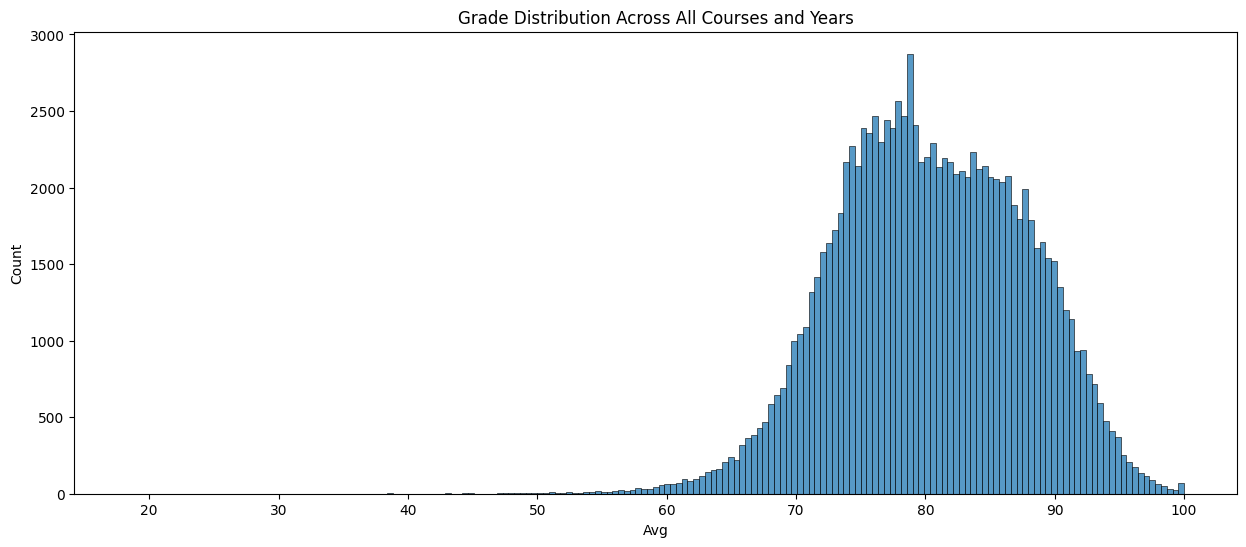

In [183]:
# Overall grade distribution patterns
plt.figure(figsize=(15, 6))

# Distribution of grades
plt.figure(figsize=(15, 6))
sns.histplot(data=df, x='Avg')
plt.title("Grade Distribution Across All Courses and Years")

In [211]:
# Drop rows with section as 'OVERALL'
df = df[df['Section'] != 'OVERALL']

# Feature engineering
df['SubjectCourse'] = df['Subject'] + df['Course'].astype(str)
df['CourseLevel'] = df['Course'].astype(str).apply(lambda x: x[0])
df['Years_Since_Start'] = df['Year'] - df['Year'].min()

# Excluding avg since we'll use course avg rolling stats
previous_stats = ['Median', 'Percentile (25)', 'Percentile (75)', 'High', 'Low',
                 '<50', '50-54', '55-59', '60-63', '64-67', '68-71',
                 '72-75', '76-79', '80-84', '85-89', '90-100']

for stat in previous_stats:
    df[f'Prev_{stat}'] = df.groupby('SubjectCourse')[stat].shift(1)
    df[f'Prof_Prev_{stat}'] = df.groupby('Professor')[stat].shift(1)  
    
# Professor experience (number of courses taught)
df['Prof_Courses_Taught'] = df.groupby('Professor').cumcount()

df['Course_Avg_Roll_1y'] = df.groupby('SubjectCourse')['Avg'].transform(
    lambda x: x.shift(1).rolling(window=2, min_periods=1).mean()
)
df['Course_Min_Last_3y'] = df.groupby('SubjectCourse')['Avg'].transform(
    lambda x: x.shift(1).rolling(6).min()
)
df['Course_Max_Last_3y'] = df.groupby('SubjectCourse')['Avg'].transform(
    lambda x: x.shift(1).rolling(6).max()
)
df['Course_Std_Last_3y'] = df.groupby('SubjectCourse')['Avg'].transform(
    lambda x: x.shift(1).rolling(6).std()
)

df = df.sort_values(['Year', 'Session'])

df.to_csv('../data/processed/ubcv_grades_processed.csv', index=False)

display(df)

,Campus,Year,Session,Subject,Course,Detail,Section,Title,Professor,Enrolled,...,Prof_Prev_80-84,Prev_85-89,Prof_Prev_85-89,Prev_90-100,Prof_Prev_90-100,Prof_Courses_Taught,Course_Avg_Roll_1y,Course_Min_Last_3y,Course_Max_Last_3y,Course_Std_Last_3y
0,UBCV,2014,S,APBI,100,NaN,98A,Soil and the Global Environment,Sandra Brown,16.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,UBCV,2014,S,APBI,200,NaN,98A,Introduction to Soil Science,Marie-Claude Fortin,23.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,UBCV,2014,S,APBI,314,NaN,941,Animals and Society,David Fraser;Elisabeth Helen Ormandy;Elisabeth...,24.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
6,UBCV,2014,S,APBI,315,NaN,941,Animal Welfare and the Ethics of Animal Use,David Fraser;Kristen Walker,22.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
9,UBCV,2014,S,APBI,497,B,001,Directed Studies,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,UBCV,2023,W,RMST,321,NaN,201,French Literature from the Middle Ages to the ...,Patrick Moran,NaN,...,5.0,5.0,12.0,5.0,9.0,20.0,81.85,NaN,NaN,NaN
8,UBCV,2023,W,RMST,324,NaN,101,Quebecois Literature and Culture,Isabella Huberman,NaN,...,10.0,NaN,10.0,NaN,10.0,2.0,NaN,NaN,NaN,NaN
9,UBCV,2023,W,RMST,341,NaN,101,Italian Literature and Culture of the Medieval...,Daniela Boccassini,NaN,...,0.0,NaN,6.0,NaN,3.0,21.0,NaN,NaN,NaN,NaN
10,UBCV,2023,W,RMST,345,NaN,101,Italian Fascism in Interdisciplinary Perspective,Carlo Testa,NaN,...,1.0,3.0,1.0,0.0,2.0,25.0,77.00,NaN,NaN,NaN


In [185]:
split_year = df['Year'].quantile(0.8)
train_df = df[df['Year'] < split_year]
test_df = df[df['Year'] >= split_year]

display(train_df.head())
display(test_df.head())

,Campus,Year,Session,Subject,Course,Detail,Section,Title,Professor,Enrolled,...,Prof_Prev_80-84,Prev_85-89,Prof_Prev_85-89,Prev_90-100,Prof_Prev_90-100,Prof_Courses_Taught,Course_Avg_Roll_1y,Course_Min_Last_3y,Course_Max_Last_3y,Course_Std_Last_3y
0,UBCV,2014,S,APBI,100,NaN,98A,Soil and the Global Environment,Sandra Brown,16.0,...,NaN,2.0,4.0,5.0,3.0,15.0,71.759511,NaN,NaN,NaN
2,UBCV,2014,S,APBI,200,NaN,98A,Introduction to Soil Science,Marie-Claude Fortin,23.0,...,NaN,3.0,NaN,3.0,NaN,0.0,72.508418,69.200000,80.295455,3.844003
4,UBCV,2014,S,APBI,314,NaN,941,Animals and Society,David Fraser;Elisabeth Helen Ormandy;Elisabeth...,24.0,...,NaN,9.0,NaN,10.0,NaN,0.0,82.091699,80.482143,85.106383,1.689341
6,UBCV,2014,S,APBI,315,NaN,941,Animal Welfare and the Ethics of Animal Use,David Fraser;Kristen Walker,22.0,...,NaN,6.0,NaN,2.0,NaN,0.0,79.561404,72.393939,84.761905,5.218369
9,UBCV,2014,S,APBI,497,B,001,Directed Studies,NaN,10.0,...,NaN,3.0,NaN,8.0,NaN,NaN,89.122596,87.833333,92.166667,1.517396


,Campus,Year,Session,Subject,Course,Detail,Section,Title,Professor,Enrolled,...,Prof_Prev_80-84,Prev_85-89,Prof_Prev_85-89,Prev_90-100,Prof_Prev_90-100,Prof_Courses_Taught,Course_Avg_Roll_1y,Course_Min_Last_3y,Course_Max_Last_3y,Course_Std_Last_3y
0,UBCV,2022,S,CNPS,362,NaN,922,Basic Interviewing Skills,Shekoofeh Skrenes,NaN,...,0.0,14.0,0.0,37.0,8.0,9.0,90.40,83.461538,90.5,2.869299
1,UBCV,2022,S,CNPS,362,NaN,923,Basic Interviewing Skills,Julia Iman O'Loughlin,NaN,...,NaN,9.0,NaN,4.0,NaN,0.0,88.95,83.461538,90.5,2.692645
2,UBCV,2022,S,CNPS,362,NaN,952,Basic Interviewing Skills,Alyson Quinn,NaN,...,5.0,5.0,2.0,6.0,2.0,4.0,87.70,83.461538,90.5,2.585525
3,UBCV,2022,S,CNPS,363,NaN,93Q,Career Counselling,Janet Vaughan Marshall,NaN,...,2.0,15.0,6.0,5.0,7.0,67.0,84.60,83.100000,90.0,2.308246
4,UBCV,2022,S,CNPS,363,NaN,93S,Career Counselling,Janet Vaughan Marshall,NaN,...,2.0,16.0,16.0,8.0,8.0,68.0,84.20,83.100000,90.0,2.317254


In [186]:
# Column types
ordinal_cols = ['CourseLevel', 'Years_Since_Start', 'Prof_Courses_Taught', 'Year']

categorical_cols = ['Campus', 'Session', 'SubjectCourse', 'Professor', 'Subject']

numeric_cols = [
                'Course_Avg_Roll_1y',
                'Course_Min_Last_3y', 
                'Course_Max_Last_3y', 
                'Course_Std_Last_3y']

drop_cols = ['Reported', 'Section', 'Detail', 'Median', 
                'Percentile (25)', 'Percentile (75)', 'High', 'Low',
                '<50', '50-54', '55-59', '60-63', '64-67', '68-71', 
                '72-75', '76-79', '80-84', '85-89', '90-100']

numeric_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', drop='if_binary')
)

ordinal_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
)

preprocessor = make_column_transformer(
    (numeric_pipeline, numeric_cols),
    (categorical_pipeline, categorical_cols),
    (ordinal_pipeline, ordinal_cols),
    ("drop", drop_cols),
)

In [187]:
X_train = train_df.drop(columns=['Avg'])
y_train = train_df['Avg']
X_test = test_df.drop(columns=['Avg'])
y_test = test_df['Avg']

X_train['Section'] = X_train['Section'].astype(str)

display(X_train.head())

,Campus,Year,Session,Subject,Course,Detail,Section,Title,Professor,Enrolled,...,Prof_Prev_80-84,Prev_85-89,Prof_Prev_85-89,Prev_90-100,Prof_Prev_90-100,Prof_Courses_Taught,Course_Avg_Roll_1y,Course_Min_Last_3y,Course_Max_Last_3y,Course_Std_Last_3y
0,UBCV,2014,S,APBI,100,NaN,98A,Soil and the Global Environment,Sandra Brown,16.0,...,NaN,2.0,4.0,5.0,3.0,15.0,71.759511,NaN,NaN,NaN
2,UBCV,2014,S,APBI,200,NaN,98A,Introduction to Soil Science,Marie-Claude Fortin,23.0,...,NaN,3.0,NaN,3.0,NaN,0.0,72.508418,69.200000,80.295455,3.844003
4,UBCV,2014,S,APBI,314,NaN,941,Animals and Society,David Fraser;Elisabeth Helen Ormandy;Elisabeth...,24.0,...,NaN,9.0,NaN,10.0,NaN,0.0,82.091699,80.482143,85.106383,1.689341
6,UBCV,2014,S,APBI,315,NaN,941,Animal Welfare and the Ethics of Animal Use,David Fraser;Kristen Walker,22.0,...,NaN,6.0,NaN,2.0,NaN,0.0,79.561404,72.393939,84.761905,5.218369
9,UBCV,2014,S,APBI,497,B,001,Directed Studies,NaN,10.0,...,NaN,3.0,NaN,8.0,NaN,NaN,89.122596,87.833333,92.166667,1.517396


In [188]:
results = {}

dummy = DummyRegressor()

dummy.fit(X_train, y_train)
results['Dummy'] = [dummy.score(X_train, y_train), dummy.score(X_test, y_test)]

In [189]:
rg_pipe = make_pipeline(
    preprocessor,
    Ridge(random_state=42)
)

In [190]:
rg_pipe.fit(X_train, y_train)

results['Ridge'] = [rg_pipe.score(X_train, y_train), cross_val_score(rg_pipe, X_train, y_train, scoring="r2", cv=TimeSeriesSplit(n_splits=5)).mean()]
results_df = pd.DataFrame(results, index=['Train Score', 'CV Score'])

display(results_df)

/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: User

,Dummy,Ridge
Train Score,0.000000,0.885100
CV Score,-0.043436,0.656854


In [191]:
# Get the feature importances
feature_importances = pd.Series(
    rg_pipe['ridge'].coef_,
    index=rg_pipe['columntransformer'].get_feature_names_out()
)

# Convert to DataFrame and sort
importances_df = pd.DataFrame({
    'Feature': feature_importances.index,
    'Importance': feature_importances.values
})

display(importances_df.sort_values('Importance', ascending=False).head())

,Feature,Importance
13354,pipeline-2__Professor_Binod Shrestha;Sara Shne...,15.441884
2459,pipeline-2__SubjectCourse_ELEC205,13.726875
30319,pipeline-2__Professor_Sara Shneiderman;Sonam C...,13.395275
2711,pipeline-2__SubjectCourse_EOSC111,12.061023
4931,pipeline-2__SubjectCourse_MUSC153,11.234133


/var/folders/qt/p78tc4gx2576_n2rl38t_gwr0000gn/T/ipykernel_93382/965811148.py:34: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


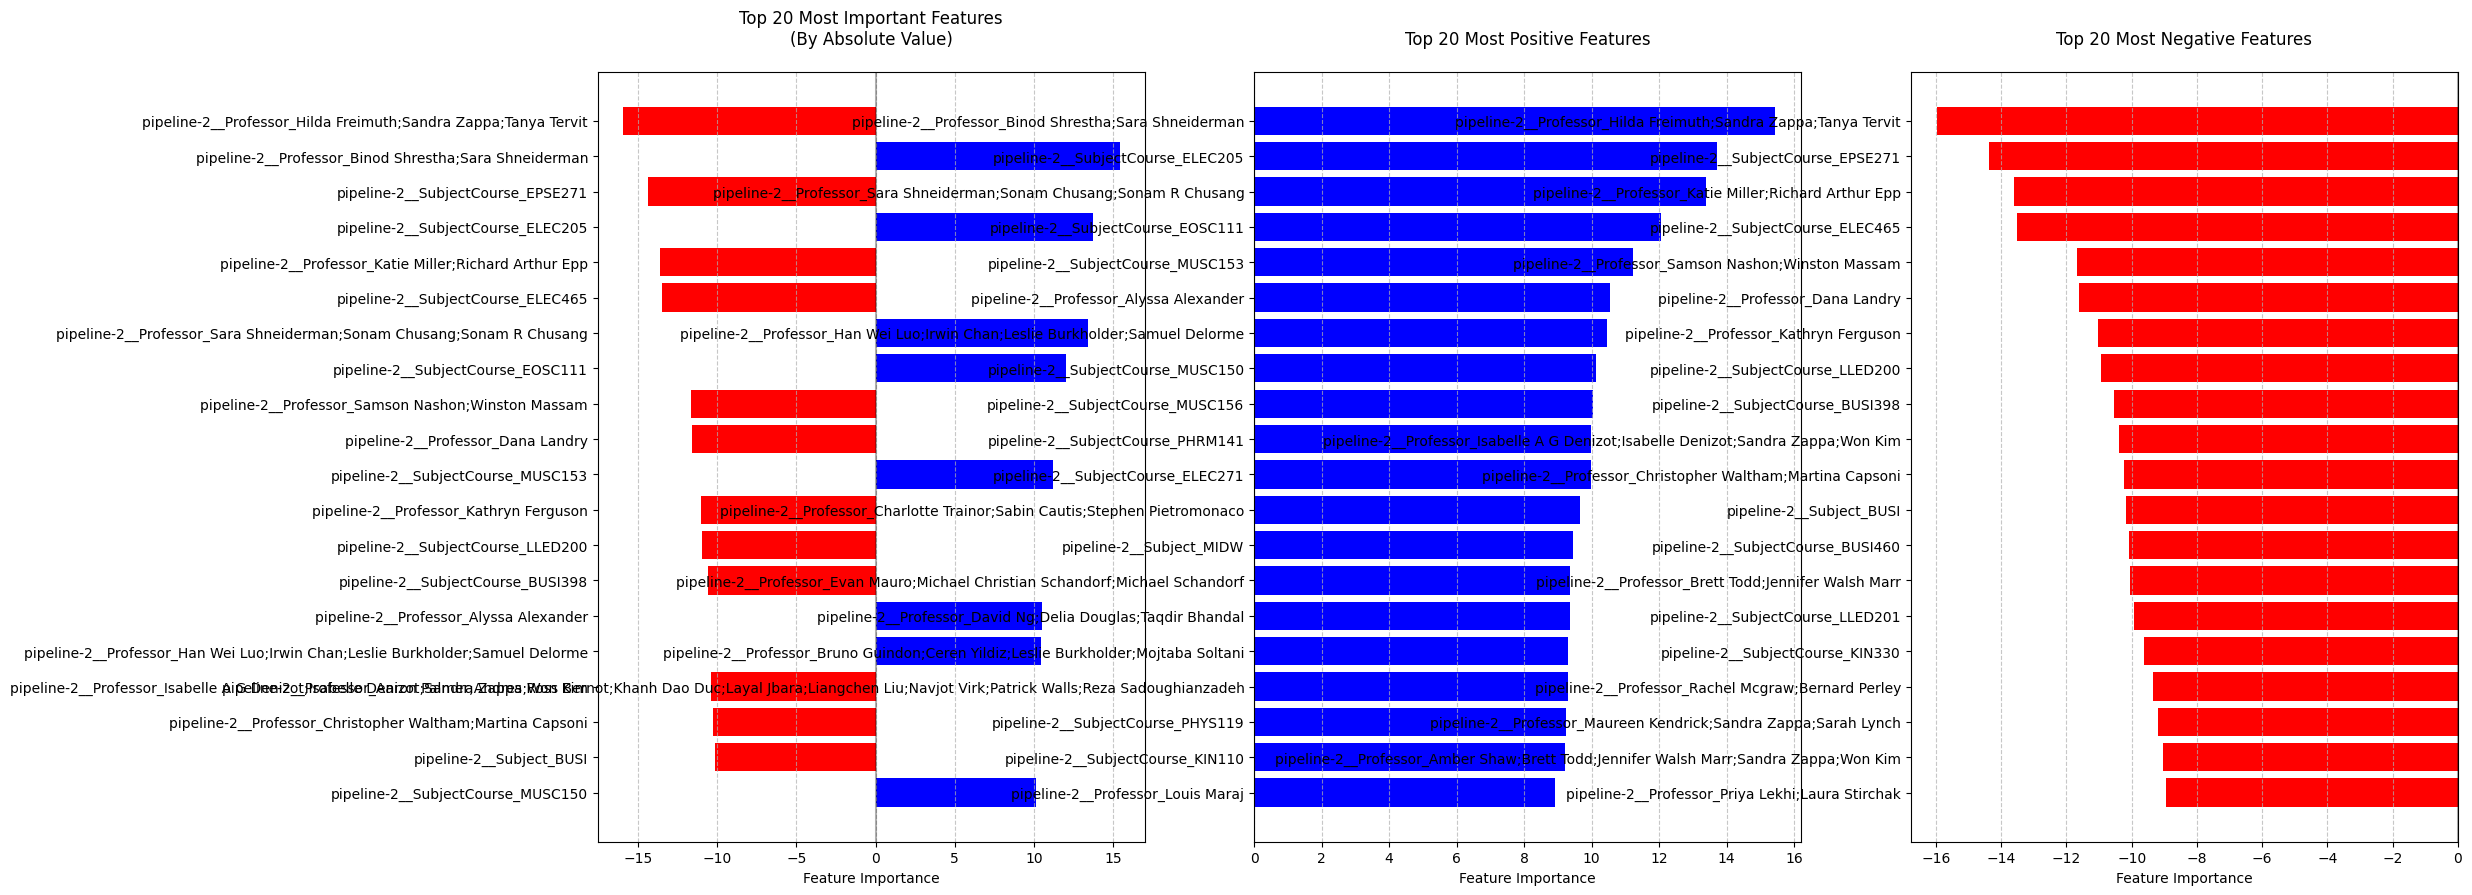

In [192]:
importances_df['Abs_Importance'] = np.abs(importances_df['Importance'])

top_overall = importances_df.sort_values('Abs_Importance', ascending=False).head(20)
top_positive = importances_df[importances_df['Importance'] > 0].sort_values('Importance', ascending=False).head(20)
top_negative = importances_df[importances_df['Importance'] < 0].sort_values('Importance').head(20)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 10))

# Plot 1: Overall most important
colors1 = ['red' if x < 0 else 'blue' for x in top_overall['Importance']]
ax1.barh(top_overall['Feature'], top_overall['Importance'], color=colors1)
ax1.set_title('Top 20 Most Important Features\n(By Absolute Value)', pad=20)
ax1.set_xlabel('Feature Importance')
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Plot 2: Top positive features
ax2.barh(top_positive['Feature'], top_positive['Importance'], color='blue')
ax2.set_title('Top 20 Most Positive Features', pad=20)
ax2.set_xlabel('Feature Importance')
ax2.invert_yaxis()
ax2.grid(axis='x', linestyle='--', alpha=0.7)
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Plot 3: Top negative features
ax3.barh(top_negative['Feature'], top_negative['Importance'], color='red')
ax3.set_title('Top 20 Most Negative Features', pad=20)
ax3.set_xlabel('Feature Importance')
ax3.invert_yaxis()
ax3.grid(axis='x', linestyle='--', alpha=0.7)
ax3.axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

,Feature,Importance,Abs_Importance,Course
2459,pipeline-2__SubjectCourse_ELEC205,13.726875,13.726875,ELEC205
2711,pipeline-2__SubjectCourse_EOSC111,12.061023,12.061023,EOSC111
4931,pipeline-2__SubjectCourse_MUSC153,11.234133,11.234133,MUSC153
4930,pipeline-2__SubjectCourse_MUSC150,10.141822,10.141822,MUSC150
4933,pipeline-2__SubjectCourse_MUSC156,10.029424,10.029424,MUSC156
5374,pipeline-2__SubjectCourse_PHRM141,9.978107,9.978107,PHRM141
2462,pipeline-2__SubjectCourse_ELEC271,9.976990,9.976990,ELEC271
5442,pipeline-2__SubjectCourse_PHYS119,9.242695,9.242695,PHYS119
3905,pipeline-2__SubjectCourse_KIN110,9.198731,9.198731,KIN110


,Feature,Importance,Abs_Importance,Course
2816,pipeline-2__SubjectCourse_EPSE271,14.366519,14.366519,EPSE271
2507,pipeline-2__SubjectCourse_ELEC465,13.510814,13.510814,ELEC465
4366,pipeline-2__SubjectCourse_LLED200,10.954205,10.954205,LLED200
982,pipeline-2__SubjectCourse_BUSI398,10.555647,10.555647,BUSI398
998,pipeline-2__SubjectCourse_BUSI460,10.077111,10.077111,BUSI460
4367,pipeline-2__SubjectCourse_LLED201,9.931360,9.931360,LLED201
3936,pipeline-2__SubjectCourse_KIN330,9.620729,9.620729,KIN330


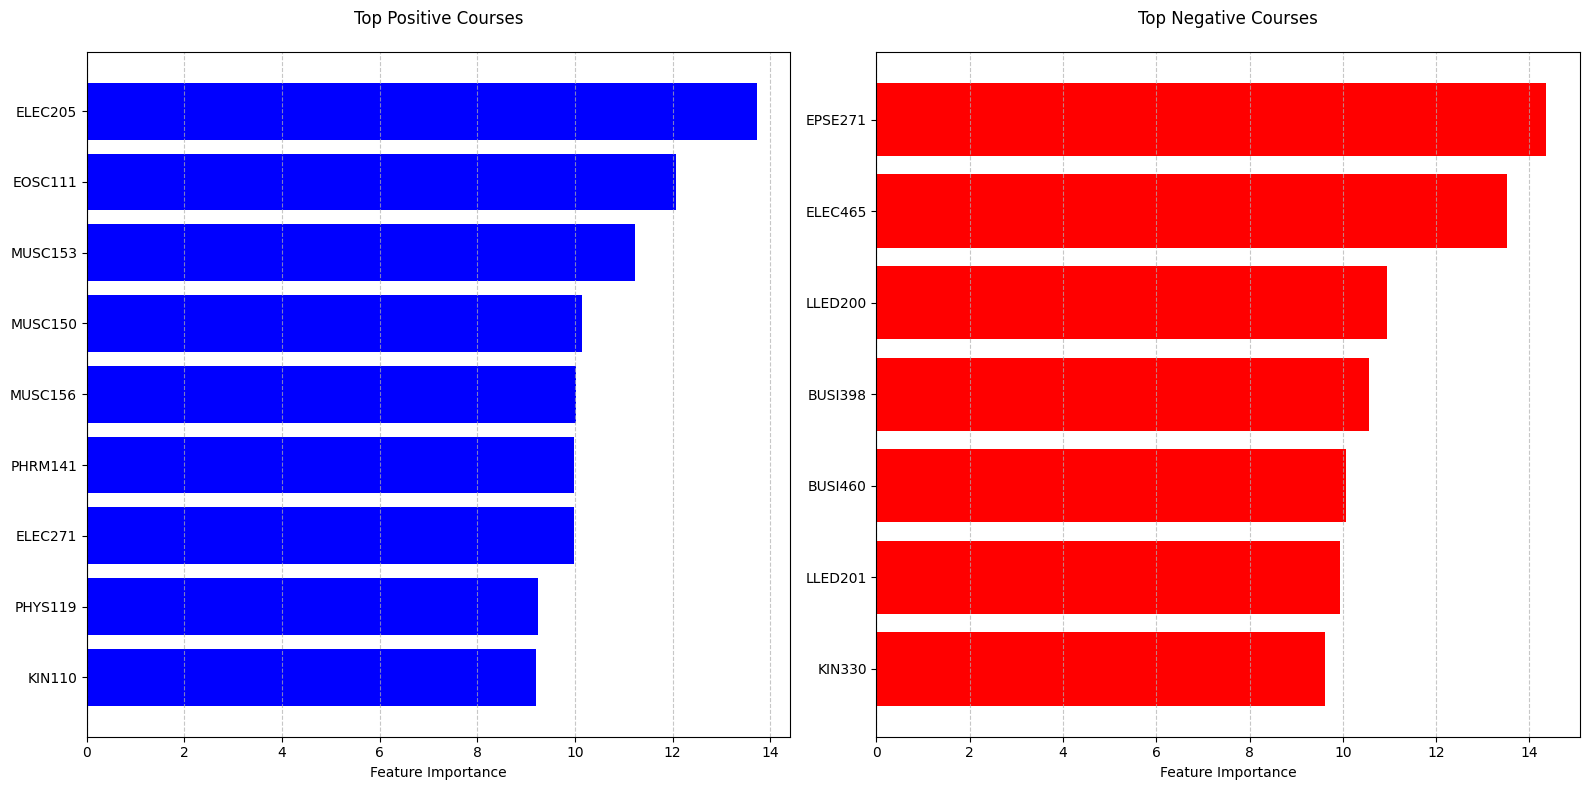

In [193]:
# Plot features/courses with the highest positive and negative coefficients
# Positive
top_positive_courses = top_positive[top_positive['Feature'].str.contains('SubjectCourse')].sort_values('Importance', ascending=False)
top_positive_courses['Course'] = top_positive_courses['Feature'].str.split('__').str[1].str.split('_').str[1]
top_positive_courses['Importance'] = top_positive_courses['Importance'].abs()
display(top_positive_courses)

# Negative
top_negative_courses = top_negative[top_negative['Feature'].str.contains('SubjectCourse')].sort_values('Importance')
top_negative_courses['Course'] = top_negative_courses['Feature'].str.split('__').str[1].str.split('_').str[1]
top_negative_courses['Importance'] = top_negative_courses['Importance'].abs()
display(top_negative_courses)

# plot both positive and negative courses
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Positive
ax1.barh(top_positive_courses['Course'], top_positive_courses['Importance'], color='blue')
ax1.set_title('Top Positive Courses', pad=20)
ax1.set_xlabel('Feature Importance')
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Negative
ax2.barh(top_negative_courses['Course'], top_negative_courses['Importance'], color='red')
ax2.set_title('Top Negative Courses', pad=20)
ax2.set_xlabel('Feature Importance')
ax2.invert_yaxis()
ax2.grid(axis='x', linestyle='--', alpha=0.7)
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

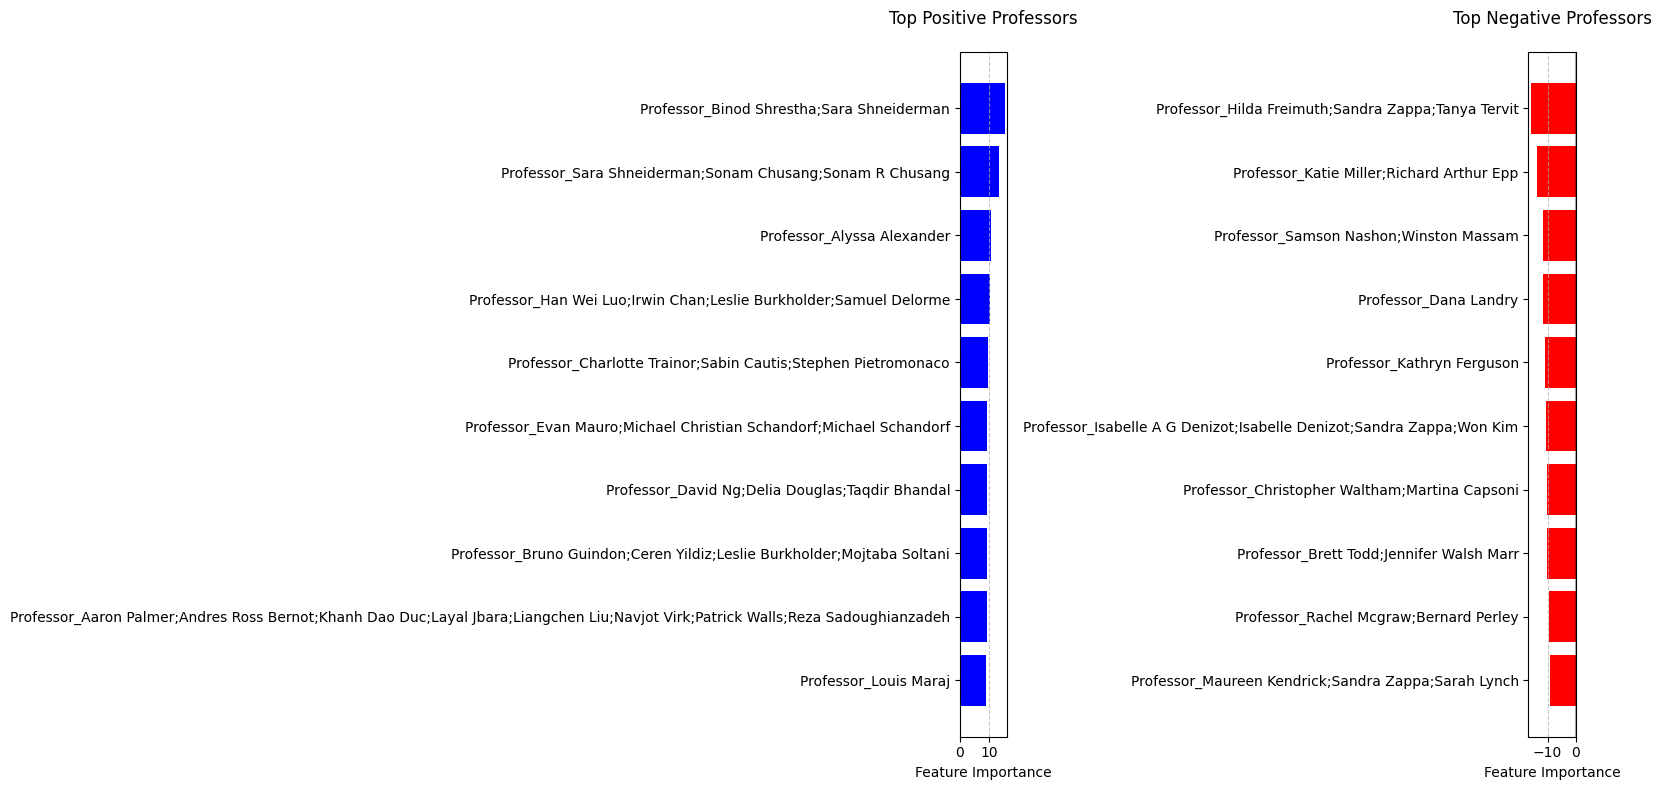

In [194]:
professor_importances = importances_df[importances_df['Feature'].str.contains('Professor')].copy()
professor_importances['Abs_Importance'] = np.abs(professor_importances['Importance'])

top_positive_profs = professor_importances[professor_importances['Importance'] > 0].sort_values('Importance', ascending=False).head(10)
top_negative_profs = professor_importances[professor_importances['Importance'] < 0].sort_values('Importance').head(10)

top_positive_profs['Professor'] = top_positive_profs['Feature'].str.split('__').str[1]
top_negative_profs['Professor'] = top_negative_profs['Feature'].str.split('__').str[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Positive
ax1.barh(top_positive_profs['Professor'], top_positive_profs['Importance'], color='blue')
ax1.set_title('Top Positive Professors', pad=20)
ax1.set_xlabel('Feature Importance')
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Negative
ax2.barh(top_negative_profs['Professor'], top_negative_profs['Importance'], color='red')
ax2.set_title('Top Negative Professors', pad=20)
ax2.set_xlabel('Feature Importance')
ax2.invert_yaxis()
ax2.grid(axis='x', linestyle='--', alpha=0.7)
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

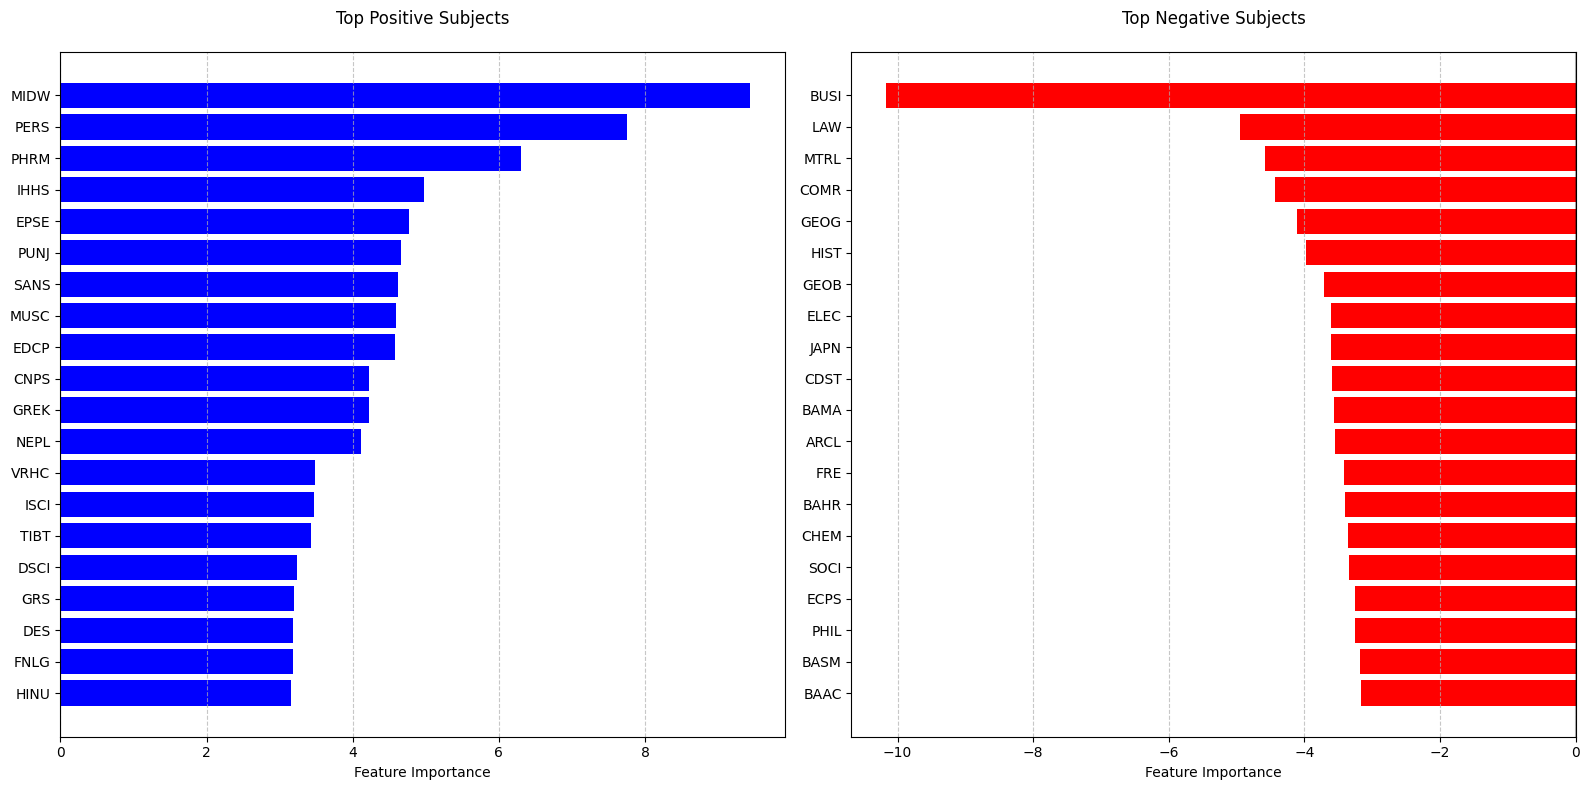

In [195]:
subject_importances = importances_df[importances_df['Feature'].str.contains('Subject_')].copy()
subject_importances['Abs_Importance'] = np.abs(subject_importances['Importance'])

top_positive_subjects = subject_importances[subject_importances['Importance'] > 0].sort_values('Importance', ascending=False).head(20)
top_negative_subjects = subject_importances[subject_importances['Importance'] < 0].sort_values('Importance').head(20)

top_positive_subjects['Subject'] = top_positive_subjects['Feature'].str.split('__').str[1].str.split('_').str[1]
top_negative_subjects['Subject'] = top_negative_subjects['Feature'].str.split('__').str[1].str.split('_').str[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Positive
ax1.barh(top_positive_subjects['Subject'], top_positive_subjects['Importance'], color='blue')
ax1.set_title('Top Positive Subjects', pad=20)
ax1.set_xlabel('Feature Importance')
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Negative
ax2.barh(top_negative_subjects['Subject'], top_negative_subjects['Importance'], color='red')
ax2.set_title('Top Negative Subjects', pad=20)
ax2.set_xlabel('Feature Importance')
ax2.invert_yaxis()
ax2.grid(axis='x', linestyle='--', alpha=0.7)
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

In [196]:
ridge_param_dist = {
    'ridge__alpha': loguniform(0.1, 100)
}

rg_search = RandomizedSearchCV(
        rg_pipe,
        param_distributions=ridge_param_dist,
        n_iter=50,
        cv=TimeSeriesSplit(n_splits=5),
        scoring='r2',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
rg_search.fit(X_train, y_train)
print(f"Best score: {rg_search.best_score_:.4f}")
print(f"Best parameters: {rg_search.best_params_}\n")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: User

Best score: 0.6603
Best parameters: {'ridge__alpha': np.float64(2.0914981329035602)}



In [197]:
# Ridge with tuned hyperparameters
rg_tuned_pipe = make_pipeline(
    preprocessor,
    Ridge(alpha=2.091, random_state=42)
)

rg_tuned_pipe.fit(X_train, y_train)

results['Tuned Ridge'] = [rg_search.score(X_train, y_train), cross_val_score(rg_search, X_train, y_train, scoring="r2", cv=TimeSeriesSplit(n_splits=5)).mean()]
results_df = pd.DataFrame(results, index=['Train Score', 'CV Score'])

display(results_df)

/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: User

,Dummy,Ridge,Tuned Ridge
Train Score,0.000000,0.885100,0.858411
CV Score,-0.043436,0.656854,0.660259


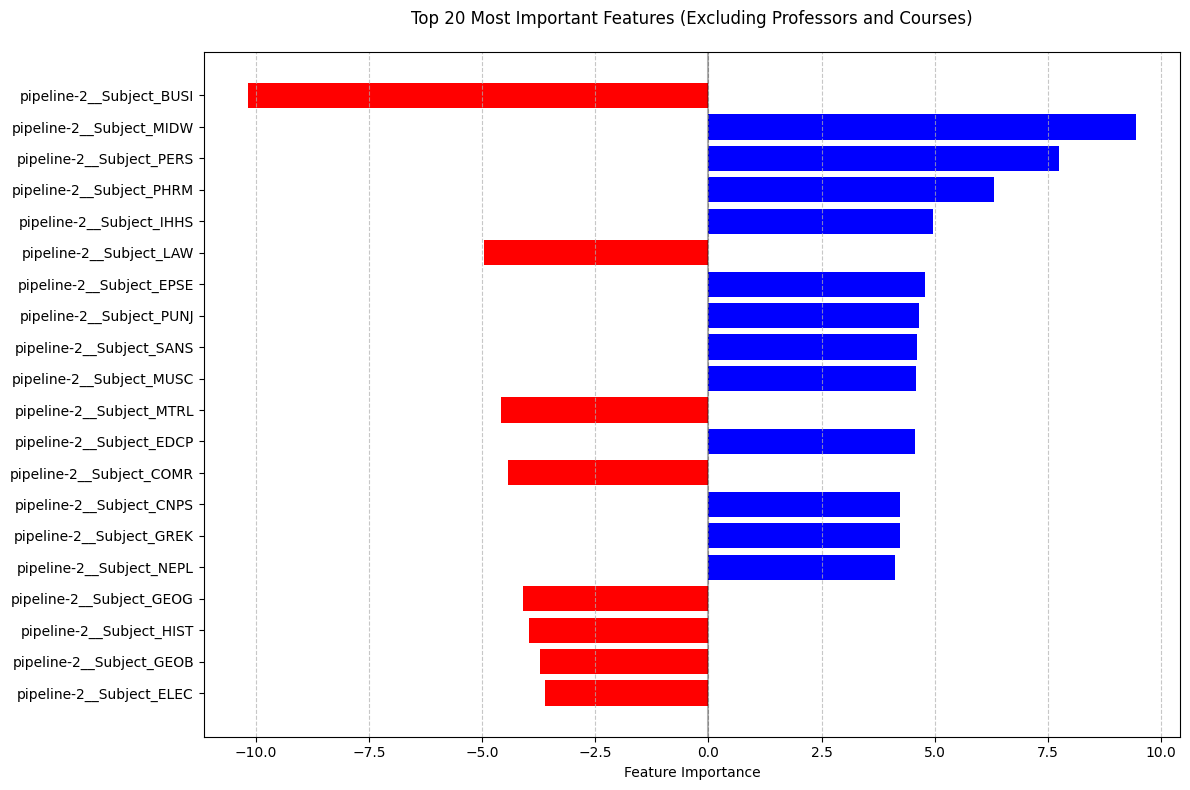

In [199]:
# Features that are not professors nor subject courses
other_importances = importances_df[~importances_df['Feature'].str.contains('Professor|SubjectCourse')].copy()
other_importances['Abs_Importance'] = np.abs(other_importances['Importance'])

top_other = other_importances.sort_values('Abs_Importance', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(12, 8))

colors = ['red' if x < 0 else 'blue' for x in top_other['Importance']]
ax.barh(top_other['Feature'], top_other['Importance'], color=colors)
ax.set_title('Top 20 Most Important Features (Excluding Professors and Courses)', pad=20)
ax.set_xlabel('Feature Importance')
ax.invert_yaxis()
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


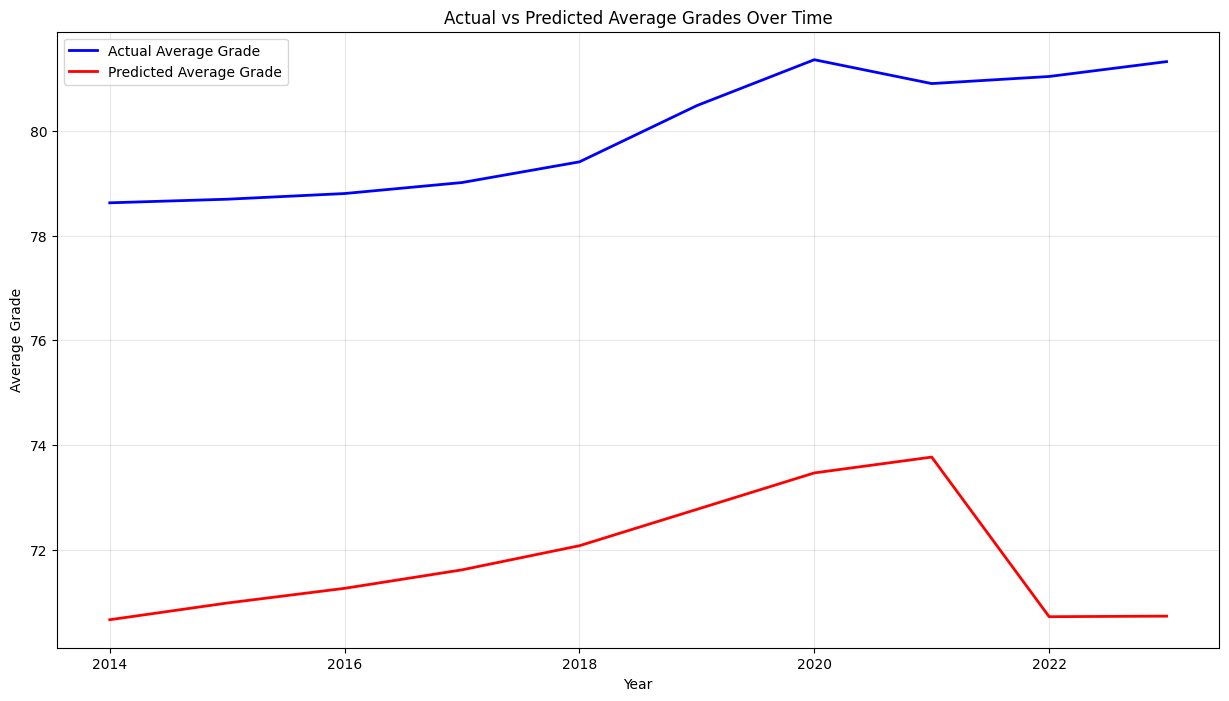

In [256]:
plt.figure(figsize=(15, 8))

years = df['Year'].unique()
years.sort()

avg_actual = [df[df['Year'] == year]['Avg'].mean() for year in years]
predictions = rg_tuned_pipe.predict(df.drop(columns=['Avg']))
avg_pred = [predictions[df['Year'] == year].mean() for year in years]

plt.plot(years, avg_actual, 'b-', linewidth=2, label='Actual Average Grade')
plt.plot(years, avg_pred, 'r-', linewidth=2, label='Predicted Average Grade')

plt.xlabel('Year')
plt.ylabel('Average Grade')
plt.title('Actual vs Predicted Average Grades Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [257]:
# Evaluate model on r2, mse, and mape
def evaluate_model(model, X_train, y_train, X_test, y_test):
    test_r2 = model.score(X_test, y_test)
    
    test_rmse = np.sqrt(np.mean((model.predict(X_test) - y_test) ** 2))
    
    test_mape = np.mean(np.abs((y_test - model.predict(X_test)) / y_test)) * 100
    
    return test_r2, test_rmse, test_mape

In [258]:
final_results = {}

test_r2, test_mse, test_mape = evaluate_model(rg_tuned_pipe, X_train, y_train, X_test, y_test)
final_results['Ridge'] = [test_r2, test_mse, test_mape]
final_results_df = pd.DataFrame(final_results, index=['Test R2', 'Test RMSE', 'Test MAPE'])

display(final_results_df)

/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Ridge
Test R2,0.519354
Test RMSE,5.021205
Test MAPE,4.842030


In [259]:
def prepare_inference_features(df, subject, course, year, campus="UBCV", session='W', professor=None):
    course_mask = (df['Subject'] == subject) & (df['Course'] == course)
    time_mask = ((df['Year'] < year) | 
                 ((df['Year'] == year) & (df['Session'] < session)))
    latest_data = df[course_mask & time_mask].iloc[-1].to_dict()

    features = {
        'Campus': campus,
        'Subject': subject,
        'Course': course,
        'Year': year,
        'Session': session,
        'SubjectCourse': f"{subject}{course}",
        'CourseLevel': latest_data['CourseLevel'],
        'Years_Since_Start': year - df['Year'].min(),
        'Course_Avg_Roll_1y': latest_data['Course_Avg_Roll_1y'],
        'Course_Min_Last_3y': latest_data['Course_Min_Last_3y'],
        'Course_Max_Last_3y': latest_data['Course_Max_Last_3y'],
        'Course_Std_Last_3y': latest_data['Course_Std_Last_3y'],
        'Professor': professor if professor else '',
        'Prof_Courses_Taught': latest_data['Prof_Courses_Taught']
    }

    for col in df.columns:
        if col.startswith('Prev_') or col.startswith('Prof_Prev_'):
            features[col] = latest_data[col]
    
    return pd.DataFrame([features])

In [260]:
df = pd.read_csv('../data/processed/ubcv_grades_processed.csv')

example_prediction = prepare_inference_features(
    df=df,
    subject='CPSC',
    course=110,
    year=2023,
    campus='UBCV',
    session='W',
    professor='John Smith'
)

rg_tuned_pipe.predict(example_prediction)

array([71.24961848])

In [263]:
dump(rg_tuned_pipe, '../models/ubcv_grade_predictor_ridge.joblib')

['../models/ubcv_grade_predictor_ridge.joblib']

In [266]:
loaded_pipeline = load('../models/ubcv_grade_predictor_ridge.joblib')
prediction = loaded_pipeline.predict(prepare_inference_features(df=df,
    subject='CPSC',
    course=110,
    year=2023,
    campus='UBCV',
    session='W',
    professor='John Smith'))
prediction

array([71.24961848])